In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import pdb
import glob
import itertools
from utils import constants as cnst
from wavelet import util, wav
from scipy.ndimage.measurements import label
from scipy import ndimage
from utils import u_arrays as ua
import numpy.ma as ma
from eod import mfg

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [38]:
msg_file = '/home/ck/DIR/cornkle/data/vera_test/cores_-40_700km2_-50points_dominant_2004_09.nc'
mfg_file = '/home/ck/DIR/cornkle/data/vera_test/cores_MFG_-40_700km2_-50points_dominant_2004_09.nc'

In [39]:
ar_msg = xr.open_dataset(msg_file)
ar_mfg = xr.open_dataset(mfg_file)

In [40]:
def filter_img(outt):
        t_thresh_size = -40
        t_thresh_cut = -50
        
        out_nogood = outt>=t_thresh_cut

        #core_min = -60

        outt[outt>=t_thresh_size] = 0
        outt[np.isnan(outt)] = 0

        labels, numL = label(outt)

        u, inv = np.unique(labels, return_inverse=True)
        n = np.bincount(inv)

        pix_nb = 28

        badinds = u[(n < pix_nb)]  # all blobs with more than 1000 pixels = 25,000km2 (meteosat regridded 5km), 200pix = 5000km2, 8pix = 200km2
        # scale 30km, radius 15km ca. 700km2 circular area equals 28 pix

        for bi in badinds:
            inds = np.where(labels == bi)
            outt[inds] = 0

        outt[outt >=t_thresh_cut] = 150

        grad = np.gradient(outt)
        outt[outt == 150] = np.nan

        nogood = np.isnan(outt) # filters edge maxima later, no maxima in -40 edge area by definition!

        tdiff = np.nanmax(outt)-np.nanmin(outt) # define background temperature for image
#         if tdiff > 28:  # temp difference of 28 degrees
#             xmin = 15
#         else:
        xmin = 10

        outt[nogood] = t_thresh_cut-xmin
        nok = np.where(abs(grad[0]) > 80)
        d = 2
        i = nok[0]
        j = nok[1]
        #edge smoothing for wavelet application
        for ii, jj in zip(i, j):
            kern = outt[ii - d:ii + d + 1, jj - d:jj + d + 1]
            outt[ii - d:ii + d + 1, jj - d:jj + d + 1] = ndimage.gaussian_filter(kern, 2, mode='nearest')
        
        nogood = np.where(outt>=t_thresh_cut)
        #outt[outt>t_thresh_size] = t_thresh_size
        
        
        return outt, out_nogood

In [41]:
np.setdiff1d(ar_mfg['time'].values, ar_msg['time'].values)

array(['2004-09-29T01:00:00.000000000', '2004-09-29T01:30:00.000000000'],
      dtype='datetime64[ns]')

In [42]:
x1 = 50
x2 = 690
y1 = 50
y2 = 250

In [112]:
mfg_img = (ar_mfg['tir'].values)[226,y1:y2,x1:x2]/100 #[5,y1:y2,x1:x2]/100
msg_img = (ar_msg['tir'].values)[226,y1:y2,x1:x2]/100#

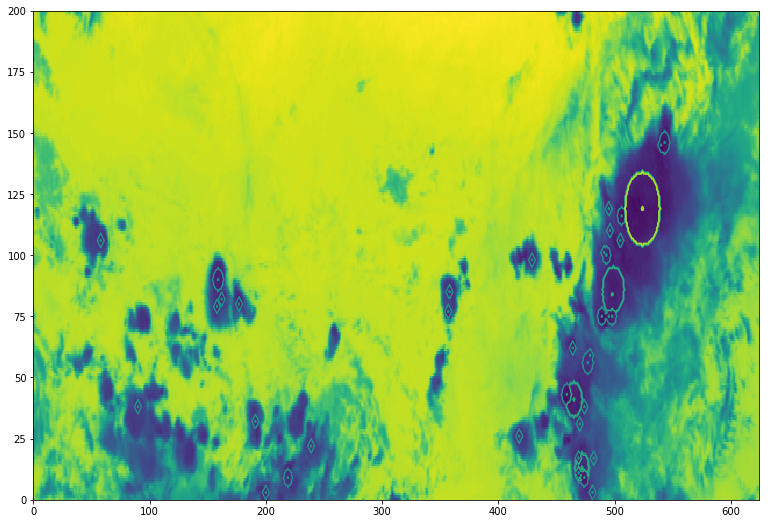

In [114]:
plt.figure(figsize=(13,9))
plt.pcolormesh(mfg_img)
plt.contour(ar_mfg['blobs'][226,y1:y2,x1:x2])

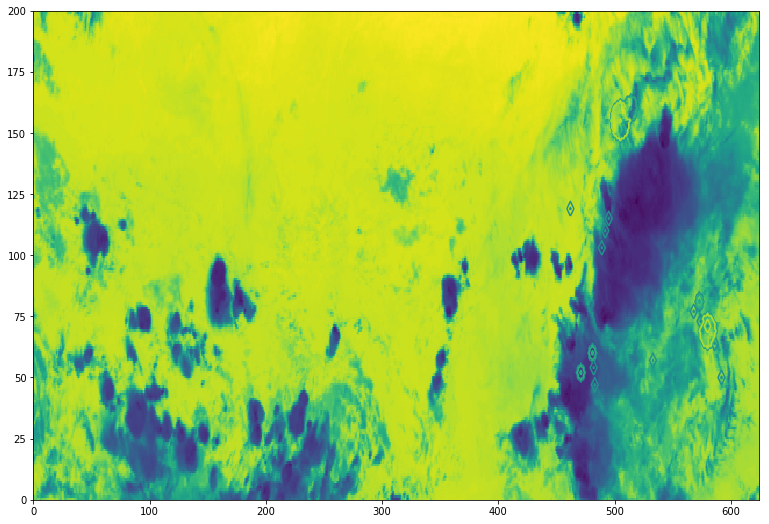

In [115]:
plt.figure(figsize=(13,9))
plt.pcolormesh(msg_img)
plt.contour(ar_msg['blobs'][5,y1:y2,x1:x2])

In [116]:
mfg_img, mfg_nogood = filter_img(mfg_img)
msg_img, msg_nogood = filter_img(msg_img)

In [117]:
mfg_nogood

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

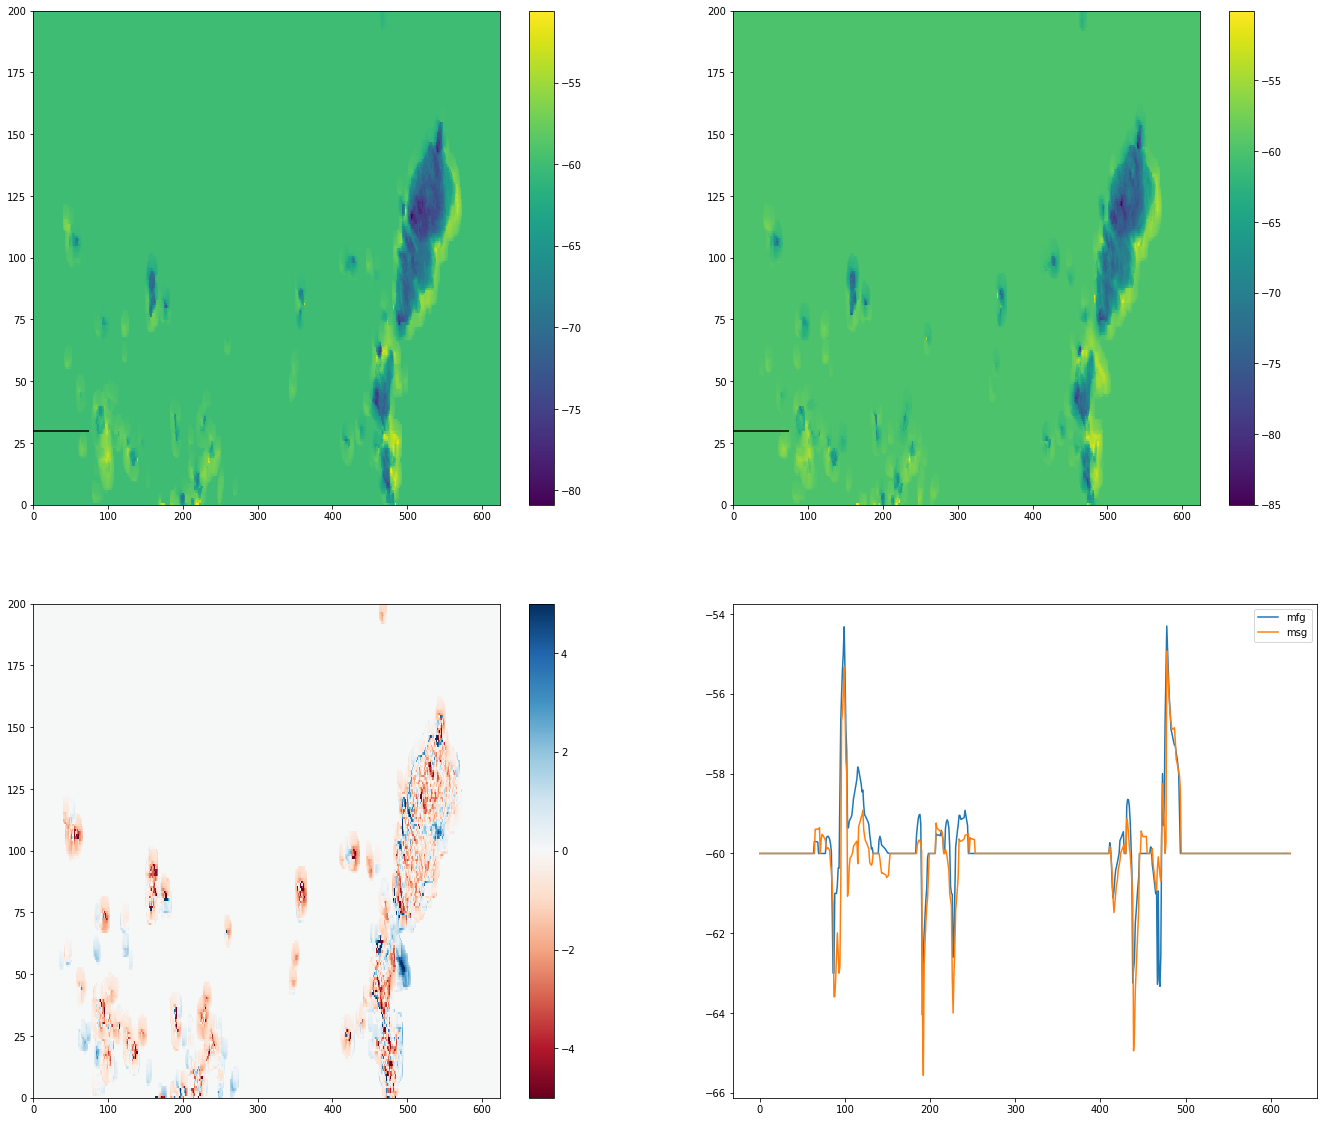

In [118]:
f = plt.figure(figsize=(23,20))
ax = f.add_subplot(221)
plt.pcolormesh(mfg_img)
plt.hlines(y=30, xmin=0, xmax=75)
plt.colorbar()
ax = f.add_subplot(222)
plt.pcolormesh(msg_img)
plt.hlines(y=30, xmin=0, xmax=75)
plt.colorbar()
ax = f.add_subplot(223)
plt.pcolormesh(msg_img-mfg_img, cmap='RdBu', vmin=-5, vmax=5)
plt.colorbar()
ax = f.add_subplot(224)
plt.plot(mfg_img[30,:], label='mfg')
plt.plot(msg_img[30,:], label='msg')

plt.legend()

In [119]:
mfg_pow = util.waveletT(mfg_img, dataset='METEOSAT5K_vera')
msg_pow = util.waveletT(msg_img, dataset='METEOSAT5K_vera')

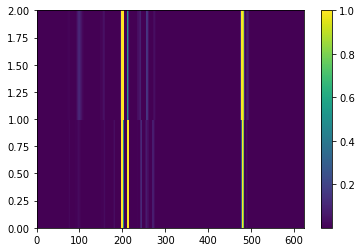

In [120]:
plt.pcolormesh(msg_pow['t'][:,0,:], vmax=1)
plt.colorbar()

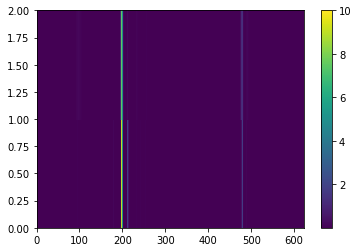

In [121]:
plt.pcolormesh(mfg_pow['t'][:,0,:], vmax=10)
plt.colorbar()

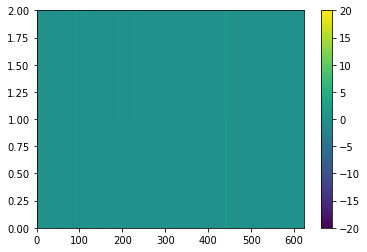

In [122]:
plt.pcolormesh(msg_pow['t'][:,30,:]-mfg_pow['t'][:,30,:], vmin=-20, vmax=20)
plt.colorbar()

In [123]:
arr = msg_pow['scales']

In [124]:
arr

array([25.        , 35.35533906])

In [125]:
def find_scales_dominant(wav, outt, thresh=-50, core_min=-65, no_good=None):
    outt[outt >= thresh] = np.nan

    arr = np.array(wav['scales'], dtype=str)

    scale_ind = range(arr.size)

    figure = np.zeros_like(outt)

    wll = wav['t']

    maxoutt = (
        wll == ndimage.maximum_filter(wll, (5,4,4), mode='reflect',   # 5,4,4
                                      cval=np.amax(wll) + 1))  # (np.round(orig / 5))

    yyy = []
    xxx = []
    scal = []
    scale_list = []
    for nb in scale_ind[::-1]:

        orig = float(arr[nb])

        scale = int(np.round(orig))

        #print(np.round(orig))

        wl = wll[nb, :, :]
        wl[no_good] = 0
        maxout = maxoutt[nb, :, :]

        try:
            yy, xx = np.where((maxout == 1) & (outt <= core_min)  &  (wl > orig**.5)) #  #  &
        except IndexError:
            continue

        #print(outt[yy,xx])
        if len(outt[yy,xx]) >=1:
            scale_list.append((np.round(orig), outt[yy,xx]))

        for y, x in zip(yy, xx):

            ss = orig
            iscale = (np.ceil(ss / 2. / 5.)).astype(int)

            ycirc, xcirc = ua.draw_cut_circle(x, y, iscale, outt)

            figure[ycirc, xcirc] = scale  #outt
            figure[y,x] = scale * -1
            xxx.append(x)
            yyy.append(y)
            scal.append(orig)
    print(scale_list)
    return figure

In [126]:
def find_scales_small(wav, outt, thresh=-45,core_min=-65, no_good=None):
    outt[outt >= thresh] = np.nan

    arr = np.array(wav['scales'], dtype=str)

    scale_ind = range(arr.size)

    figure = np.zeros_like(outt)

    wll = wav['t']

    yyy = []
    xxx = []
    scal = []
    scale_list = []
    
    power_img = np.sum(wll, axis=0)
    
    for nb in scale_ind[::-1]:

        orig = float(arr[nb])

        scale = int(np.round(orig))

        #print(np.round(orig))

        wl = wll[nb, :, :]
        #wl[no_good] = 0
        #maxout = maxoutt[nb, :, :]
        
        maxout = (
            wl == ndimage.maximum_filter(wl, (5, 5), mode='reflect', cval=np.amax(wl) + 1))  # (np.round(orig / 5))

        try:
            yy, xx = np.where((maxout == 1) & (outt <= core_min) &  (wl > orig**.5) ) #&  (wl > orig**.5)) #  #  &
        except IndexError:
            continue

        #print(outt[yy,xx])
        if len(outt[yy,xx]) >=1:
            scale_list.append((np.round(orig), outt[yy,xx]))

        for y, x in zip(yy, xx):
            
            if wl[y,x] == 0:
                continue
            
            ss = orig
            iscale = (np.ceil(ss / 2. / 5.)).astype(int)

            ycirc, xcirc = ua.draw_cut_circle(x, y, iscale, outt)

            figure[ycirc, xcirc] = scale  #outt
            figure[y,x] = scale * -1
            xxx.append(x)
            yyy.append(y)
            scal.append(orig)
    print(scale_list)
    return figure, power_img

In [127]:
fig_msg, power_msg = find_scales_small(msg_pow, msg_img,no_good=msg_nogood)

[(35.0, array([-68.85, -68.99, -74.26, -66.75, -70.31, -73.61, -76.06, -67.  ,
       -77.14, -66.71, -78.83, -73.28, -71.28, -72.66, -73.  , -73.1 ,
       -69.31, -69.  , -71.94, -74.51, -71.97, -74.28, -74.05, -79.34,
       -80.7 , -76.49])), (25.0, array([-65.89      , -68.85      , -66.        , -78.94      ,
       -68.28      , -66.75      , -68.        , -68.25      ,
       -70.46      , -73.        , -70.29      , -76.93      ,
       -68.74      , -67.68      , -74.64      , -66.71      ,
       -76.11      , -72.55      , -73.28      , -72.88      ,
       -72.66      , -68.63      , -68.61      , -73.        ,
       -68.27      , -71.94      , -72.73      , -71.97      ,
       -69.27      , -69.        , -75.        , -76.29      ,
       -66.75537643, -84.25      , -75.38      , -70.        ,
       -76.49      ]))]


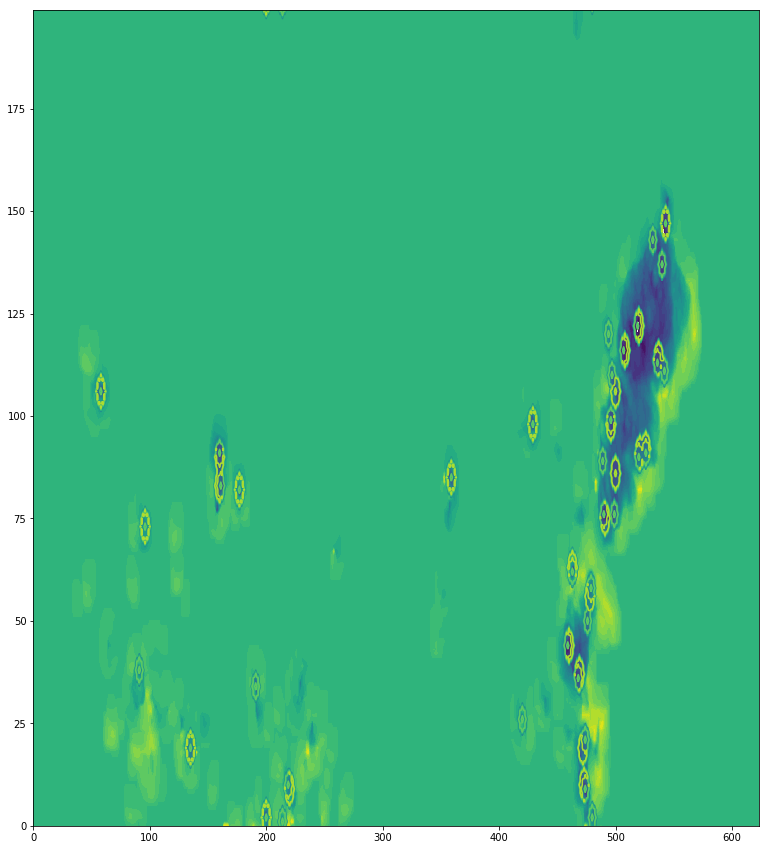

In [128]:
plt.figure(figsize=(13,15))

plt.contourf(msg_img, levels=np.arange(-80,-50,1), vmax=-50)
plt.contour(fig_msg)

In [129]:
fig_mfg, power_mfg = find_scales_small(mfg_pow, mfg_img, no_good=mfg_nogood)

[(35.0, array([-70.3 , -69.  , -74.18, -68.33, -70.32, -74.29, -65.  , -74.  ,
       -74.12, -69.11, -69.13, -67.69, -72.  , -70.  , -68.94, -69.  ,
       -70.  , -67.15, -72.  , -79.07, -74.58])), (25.0, array([-70.3 , -69.  , -73.76, -69.  , -68.69, -69.  , -70.  , -69.92,
       -74.29, -67.  , -66.79, -74.  , -76.31, -71.24, -70.17, -69.11,
       -66.82, -70.  , -69.  , -69.44, -67.21, -69.6 , -80.88, -69.54,
       -69.78, -75.  ]))]


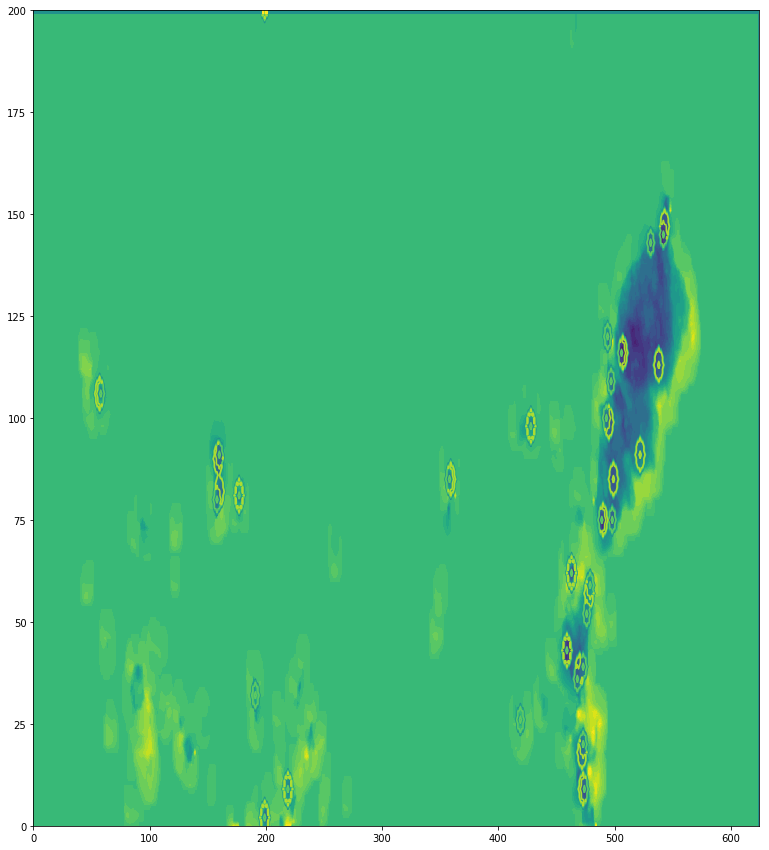

In [130]:
plt.figure(figsize=(13,15))
plt.pcolormesh(fig_mfg)
plt.contourf(mfg_img,levels=np.arange(-80,-50,1))
plt.contour(fig_mfg)

In [131]:
power_mfg[mfg_nogood] = 0
power_msg[msg_nogood] = 0

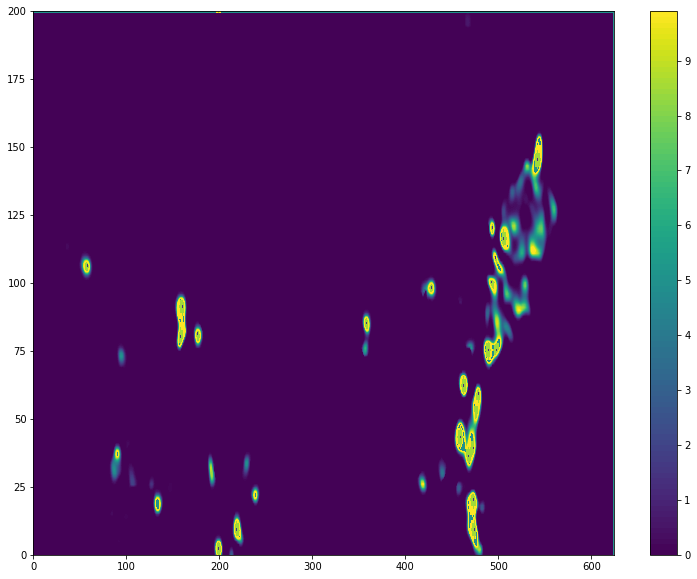

In [133]:
plt.figure(figsize=(13,10))
plt.pcolormesh(fig_mfg)
#plt.contourf(mfg_img,levels=np.arange(-80,-50,1))
plt.contourf(power_mfg, levels=np.arange(0,10,0.1))
plt.colorbar()

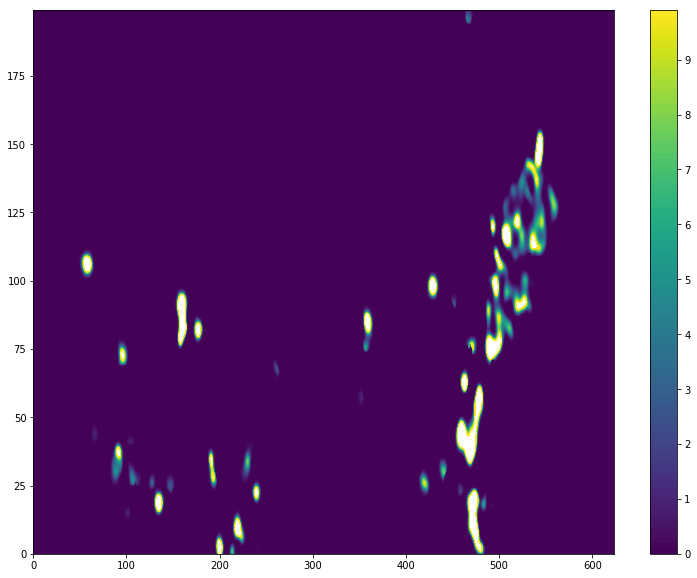

In [134]:
plt.figure(figsize=(13,10))
#plt.pcolormesh(fig_msg)
#plt.contourf(msg_img,levels=np.arange(-80,-50,1))
plt.contourf(power_msg, levels=np.arange(0,10,0.1))
plt.colorbar()

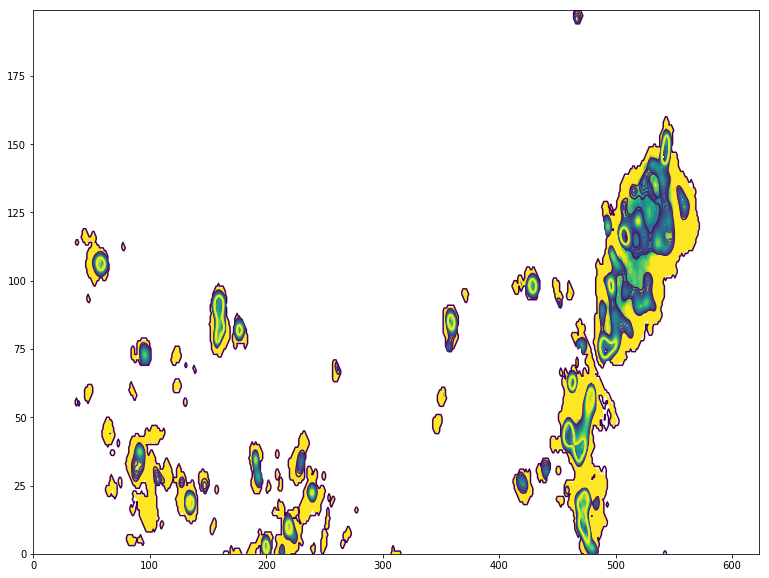

In [135]:
plt.figure(figsize=(13,10))
plt.contourf((ar_msg['tir'].values)[226,y1:y2,x1:x2]/100,levels=np.arange(-80,-50,1), vmax=-66)
plt.contour(power_msg, levels=np.arange(0,20))

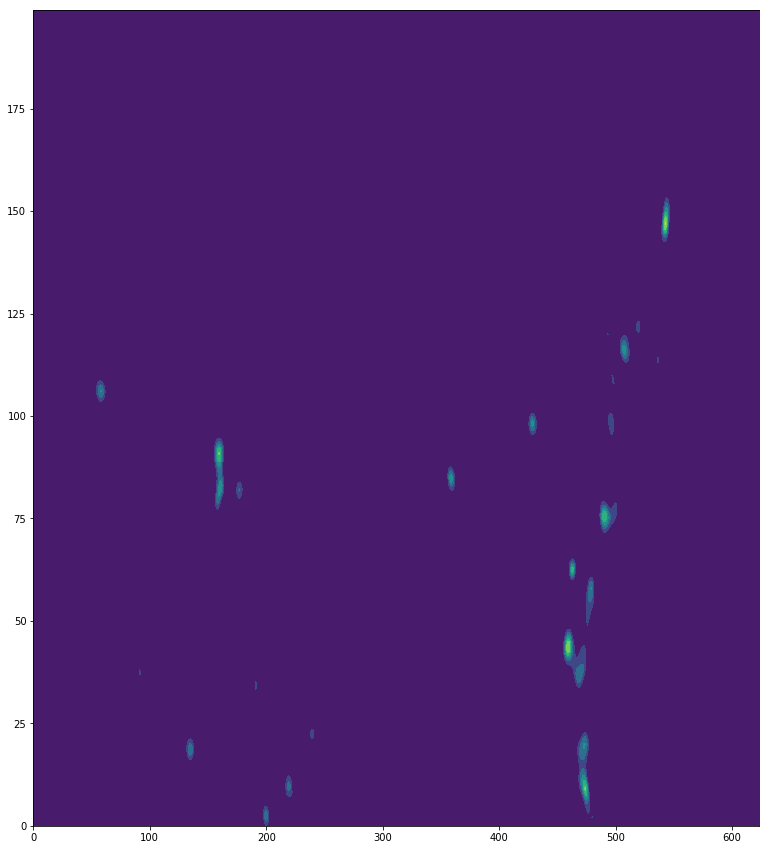

In [136]:
plt.figure(figsize=(13,15))
plt.contourf(power_msg)

In [137]:
np.sum(power_msg>= 30**.5)-np.sum(power_mfg>= 30**.5)

361

In [138]:
np.sum(fig_msg>0)-np.sum(fig_mfg>0)

360